In [265]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import random

import torch
import torch.nn as nn
from torch import Tensor
from torch.nn import Module
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader
from torch.optim import Optimizer

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using:',device)
#device='cpu'

Using: cuda


Defining dataloader

In [30]:
class CustomDataset(Dataset):
    def __init__(self, features, Device):
        # moves all to cuda
        for tensor in features:
            tensor = tensor.to(device = Device)
        self.input = features

    def __getitem__(self, index):
        x = self.input[0][index]
        y = self.input[1][index]
        return x, y
    
    def __len__(self):
        return len(self.input[1])

Defining Model

In [81]:
class Model(nn.Module):

    def __init__(self,
                 layer_sizes,
                 activation_func,
                 model_path,
                 model_name):
        """layer_sizes: first layer is input size, middle layers are linear transforms size, final layer is output size\nmodel_name: start with a '\'"""

        super(Model, self).__init__()

        self.path = model_path
        self.name = model_name

        layers = []
        for i in range(len(layer_sizes[1:])):
            #layers.append(nn.BatchNorm1d(layer_sizes[i]))
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            if i + 2 < len(layer_sizes):
                layers.append(nn.BatchNorm1d(layer_sizes[i+1]))
                layers.append(activation_func)
        self.net = nn.Sequential(*layers)

        self.to(device)

    def forward(self, x):
        x = self.net(x)
        return x
    
    def save_model(self):
        torch.save(self.state_dict(), self.path + self.name)

    def load_model(self, path, name):
        self.load_state_dict(torch.load(path + name))

Training Loop

In [ ]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
np.random.seed(0)
random.seed(0)

def training_loop(loss_func, optim, num_epochs, model, train_loader, val_loader):
    train_loss = [None] * num_epochs
    train_acc = [None] * num_epochs

    val_loss = [None] * num_epochs
    val_acc = [None] * num_epochs

    for epoch in range(num_epochs):

        # Train the model
        model.train()
        train_epoch_loss = 0.0
        correct = 0
        total = 0
        for inputs, targets in train_loader:
            inputs = inputs.to(device).float()
            targets = targets.to(device).float()

            optim.zero_grad()
            outputs = model(inputs)
            loss = loss_func(outputs, targets)
            loss.backward()
            optim.step()
            
            train_epoch_loss += loss.item() * inputs.size(0)
            sigmoid = nn.Sigmoid()
            outputs = sigmoid(outputs)
            predicted = (outputs > 0.5)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

        train_loss[epoch] = train_epoch_loss / len(train_loader.dataset)
        train_acc[epoch] = correct / total
        
        # Test the model on validation data
        model.eval()
        val_epoch_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = inputs.to(device).float()
                targets = targets.to(device).float()
            
                outputs = model(inputs)
                loss = loss_func(outputs, targets)
                sigmoid = nn.Sigmoid()
                outputs = sigmoid(outputs)
                val_epoch_loss += loss.item() * inputs.size(0)
                predicted = (outputs > 0.5)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()
        val_loss[epoch] = val_epoch_loss / len(val_loader.dataset)
        val_acc[epoch] = correct / total
        
        # Print the results for this epoch
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss[epoch]:.4f}, Train Acc: {train_acc[epoch]:.4f}, Val Loss: {val_loss[epoch]:.4f}, Val Acc: {val_acc[epoch]:.4f}')
    return train_loss, train_acc, val_loss, val_acc

Test Function

In [244]:
def test_func(loss_func, model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device).float()
            targets = targets.to(device).float()
            
            outputs = model(inputs)
            loss = loss_func(outputs, targets)
            sigmoid = nn.Sigmoid()
            outputs = sigmoid(outputs)
            test_loss += loss.item() * inputs.size(0)
            predicted = (outputs > 0.5)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    test_loss = test_loss / len(test_loader.dataset)
    test_acc = correct / total
        
    # Print the results for this epoch
    print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')
    # confusion matrix
    cm =confusion_matrix(targets.cpu(), predicted.cpu())
    return test_loss, test_acc, cm

Loading Data

In [32]:
features = pd.read_csv('features.csv')
features.head()

,age,PhD,Master's,CS,Maths,Chem,Business,Management,Marketing,Bio,...,numDegrees,avLengthJob,avLengthDegree,timeToFound,timeFromLastEd,timeFromFirstJob,timeFromLastJob,unemployedTime,simulJobs,success
0,33.778082,0,1,1,0,0,0,0,0,0,...,1,1.957650,6.0,5.0,5.0,4.584699,0.669399,1.089,0,1.0
1,27.778082,0,0,0,0,0,0,0,0,0,...,1,1.584247,3.0,7.0,7.0,7.504110,0.000000,0.920,1,1.0
2,24.778082,0,0,0,0,0,0,0,0,0,...,1,1.001145,4.0,3.0,3.0,1.419178,0.418033,2.002,0,1.0
3,37.778082,0,0,0,0,0,0,0,0,0,...,2,2.685460,5.0,21.0,18.0,12.418033,0.000000,6.412,5,1.0
4,32.778082,0,0,0,0,0,0,0,0,0,...,4,3.388026,2.5,16.0,12.0,15.000000,0.000000,0.756,1,1.0


Test and validation splits (validation split ratio applied after splitting off test data)

In [135]:
test = 0.1
val = 0.2
assert test <= 1
assert val <= 1
print(f'{len(features)}  total data points\n{int(test*100)} %  testing\n{int(val*(1-test)*100)} %  validating\n{int((1-val)*(1-test)*100)} %  training')

9524  total data points
10 %  testing
18 %  validating
72 %  training


Temporal features only:

In [166]:
temporal_features = features.drop(['PhD',"Master's",'CS','Maths','Chem','Business','Management','Marketing','Bio'], axis = 1)

# y is success one-hot encode, x is features
y = temporal_features['success']
# have to ensure a 50/50 success/fail split to avoid local minimum of all unsuccessful
y = y[y.index <= 7730].to_numpy()
y = np.array([y]).transpose()
x = temporal_features.drop(['success'], axis = 1)
x = x[x.index <= 7730].to_numpy()

min_max_scaler = preprocessing.MinMaxScaler()
x[:,0:len(x)] = min_max_scaler.fit_transform(x[:,0:len(x)])

# randomly shuffles data when splitting
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = test, random_state = 0)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = val, random_state = 0)


x_train = torch.from_numpy(x_train)
x_val = torch.from_numpy(x_val)
x_test = torch.from_numpy(x_test)
y_train = torch.from_numpy(y_train)
y_val = torch.from_numpy(y_val)
y_test = torch.from_numpy(y_test)


train_dataset_temporal = CustomDataset((x_train, y_train), device)
val_dataset_temporal = CustomDataset((x_val, y_val), device)
test_dataset_temporal = CustomDataset((x_test, y_test), device)


train_loader_temporal = DataLoader(train_dataset_temporal, batch_size = 20, shuffle = True)
val_loader_temporal = DataLoader(val_dataset_temporal, batch_size = 20, shuffle = True)
test_loader_temporal = DataLoader(test_dataset_temporal, batch_size = len(y), shuffle = True)
temporal_features.head()

,age,numJobs,numDegrees,avLengthJob,avLengthDegree,timeToFound,timeFromLastEd,timeFromFirstJob,timeFromLastJob,unemployedTime,simulJobs,success
0,33.778082,2,1,1.957650,6.0,5.0,5.0,4.584699,0.669399,1.089,0,1.0
1,27.778082,4,1,1.584247,3.0,7.0,7.0,7.504110,0.000000,0.920,1,1.0
2,24.778082,1,1,1.001145,4.0,3.0,3.0,1.419178,0.418033,2.002,0,1.0
3,37.778082,13,2,2.685460,5.0,21.0,18.0,12.418033,0.000000,6.412,5,1.0
4,32.778082,9,4,3.388026,2.5,16.0,12.0,15.000000,0.000000,0.756,1,1.0


All features except subject type

In [124]:
features_no_subject = features.drop(['CS','Maths','Chem','Business','Management','Marketing','Bio'], axis = 1)

# y is success one-hot encode, x is features
y = features_no_subject['success'].to_numpy()
y = np.array([y]).transpose()
x = features_no_subject.drop(['success'], axis = 1).to_numpy()

min_max_scaler = preprocessing.MinMaxScaler()
x[:,0:len(x)] = min_max_scaler.fit_transform(x[:,0:len(x)])

# randomly shuffles data when splitting
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = test, random_state = 0)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = val, random_state = 0)


x_train = torch.from_numpy(x_train)
x_val = torch.from_numpy(x_val)
x_test = torch.from_numpy(x_test)
y_train = torch.from_numpy(y_train)
y_val = torch.from_numpy(y_val)
y_test = torch.from_numpy(y_test)


train_dataset_no_subject = CustomDataset((x_train, y_train), device)
val_dataset_no_subject = CustomDataset((x_val, y_val), device)
test_dataset_no_subject = CustomDataset((x_test, y_test), device)


train_loader_no_subject = DataLoader(train_dataset_no_subject, batch_size = 20, shuffle = True)
val_loader_no_subject = DataLoader(val_dataset_no_subject, batch_size = 20, shuffle = True)
test_loader_no_subject = DataLoader(test_dataset_no_subject, batch_size = len(y), shuffle = True)
features_no_subject.head()

,age,PhD,Master's,numJobs,numDegrees,avLengthJob,avLengthDegree,timeToFound,timeFromLastEd,timeFromFirstJob,timeFromLastJob,unemployedTime,simulJobs,success
0,33.778082,0,1,2,1,1.957650,6.0,5.0,5.0,4.584699,0.669399,1.089,0,1.0
1,27.778082,0,0,4,1,1.584247,3.0,7.0,7.0,7.504110,0.000000,0.920,1,1.0
2,24.778082,0,0,1,1,1.001145,4.0,3.0,3.0,1.419178,0.418033,2.002,0,1.0
3,37.778082,0,0,13,2,2.685460,5.0,21.0,18.0,12.418033,0.000000,6.412,5,1.0
4,32.778082,0,0,9,4,3.388026,2.5,16.0,12.0,15.000000,0.000000,0.756,1,1.0


All features

In [125]:
# y is success one-hot encode, x is features
y = features['success']
y = np.array([y]).transpose()
x = features.drop(['success'], axis = 1).to_numpy()

min_max_scaler = preprocessing.MinMaxScaler()
x[:,0:len(x)] = min_max_scaler.fit_transform(x[:,0:len(x)])

# randomly shuffles data when splitting
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = test, random_state = 0)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = val, random_state = 0)


x_train = torch.from_numpy(x_train)
x_val = torch.from_numpy(x_val)
x_test = torch.from_numpy(x_test)
y_train = torch.from_numpy(y_train)
y_val = torch.from_numpy(y_val)
y_test = torch.from_numpy(y_test)


train_dataset_all = CustomDataset((x_train, y_train), device)
val_dataset_all = CustomDataset((x_val, y_val), device)
test_dataset_all = CustomDataset((x_test, y_test), device)


train_loader_all = DataLoader(train_dataset_all, batch_size = 20, shuffle = True)
val_loader_all = DataLoader(val_dataset_all, batch_size = 20, shuffle = True)
test_loader_all = DataLoader(test_dataset_all, batch_size = len(y), shuffle = True)
features.head()

,age,PhD,Master's,CS,Maths,Chem,Business,Management,Marketing,Bio,...,numDegrees,avLengthJob,avLengthDegree,timeToFound,timeFromLastEd,timeFromFirstJob,timeFromLastJob,unemployedTime,simulJobs,success
0,33.778082,0,1,1,0,0,0,0,0,0,...,1,1.957650,6.0,5.0,5.0,4.584699,0.669399,1.089,0,1.0
1,27.778082,0,0,0,0,0,0,0,0,0,...,1,1.584247,3.0,7.0,7.0,7.504110,0.000000,0.920,1,1.0
2,24.778082,0,0,0,0,0,0,0,0,0,...,1,1.001145,4.0,3.0,3.0,1.419178,0.418033,2.002,0,1.0
3,37.778082,0,0,0,0,0,0,0,0,0,...,2,2.685460,5.0,21.0,18.0,12.418033,0.000000,6.412,5,1.0
4,32.778082,0,0,0,0,0,0,0,0,0,...,4,3.388026,2.5,16.0,12.0,15.000000,0.000000,0.756,1,1.0


Model Training:

Temporal only

In [220]:
modelTemporal = Model((len(temporal_features.columns)-1,40,20,1), nn.ReLU(),"/Users/Tom/Documents/VSCode/Vela/",'temporal model')

In [221]:
train_loss_temporal, train_acc_temporal, val_loss_temporal, val_acc_temporal = training_loop(nn.BCEWithLogitsLoss(), torch.optim.Adam(modelTemporal.parameters(), lr = 1e-5), 2000, modelTemporal, train_loader_temporal, val_loader_temporal)

Epoch 1/2000, Train Loss: 0.7191, Train Acc: 0.5012, Val Loss: 0.7088, Val Acc: 0.5280
Epoch 2/2000, Train Loss: 0.7152, Train Acc: 0.5098, Val Loss: 0.7164, Val Acc: 0.5352
Epoch 3/2000, Train Loss: 0.7090, Train Acc: 0.5168, Val Loss: 0.7054, Val Acc: 0.5359
Epoch 4/2000, Train Loss: 0.7067, Train Acc: 0.5215, Val Loss: 0.7027, Val Acc: 0.5381
Epoch 5/2000, Train Loss: 0.7029, Train Acc: 0.5191, Val Loss: 0.6966, Val Acc: 0.5424
Epoch 6/2000, Train Loss: 0.7001, Train Acc: 0.5294, Val Loss: 0.6935, Val Acc: 0.5611
Epoch 7/2000, Train Loss: 0.6978, Train Acc: 0.5351, Val Loss: 0.6933, Val Acc: 0.5632
Epoch 8/2000, Train Loss: 0.6943, Train Acc: 0.5436, Val Loss: 0.6886, Val Acc: 0.5726
Epoch 9/2000, Train Loss: 0.6910, Train Acc: 0.5565, Val Loss: 0.6859, Val Acc: 0.5855
Epoch 10/2000, Train Loss: 0.6890, Train Acc: 0.5603, Val Loss: 0.6843, Val Acc: 0.5876
Epoch 11/2000, Train Loss: 0.6859, Train Acc: 0.5610, Val Loss: 0.6835, Val Acc: 0.5848
Epoch 12/2000, Train Loss: 0.6860, Train 

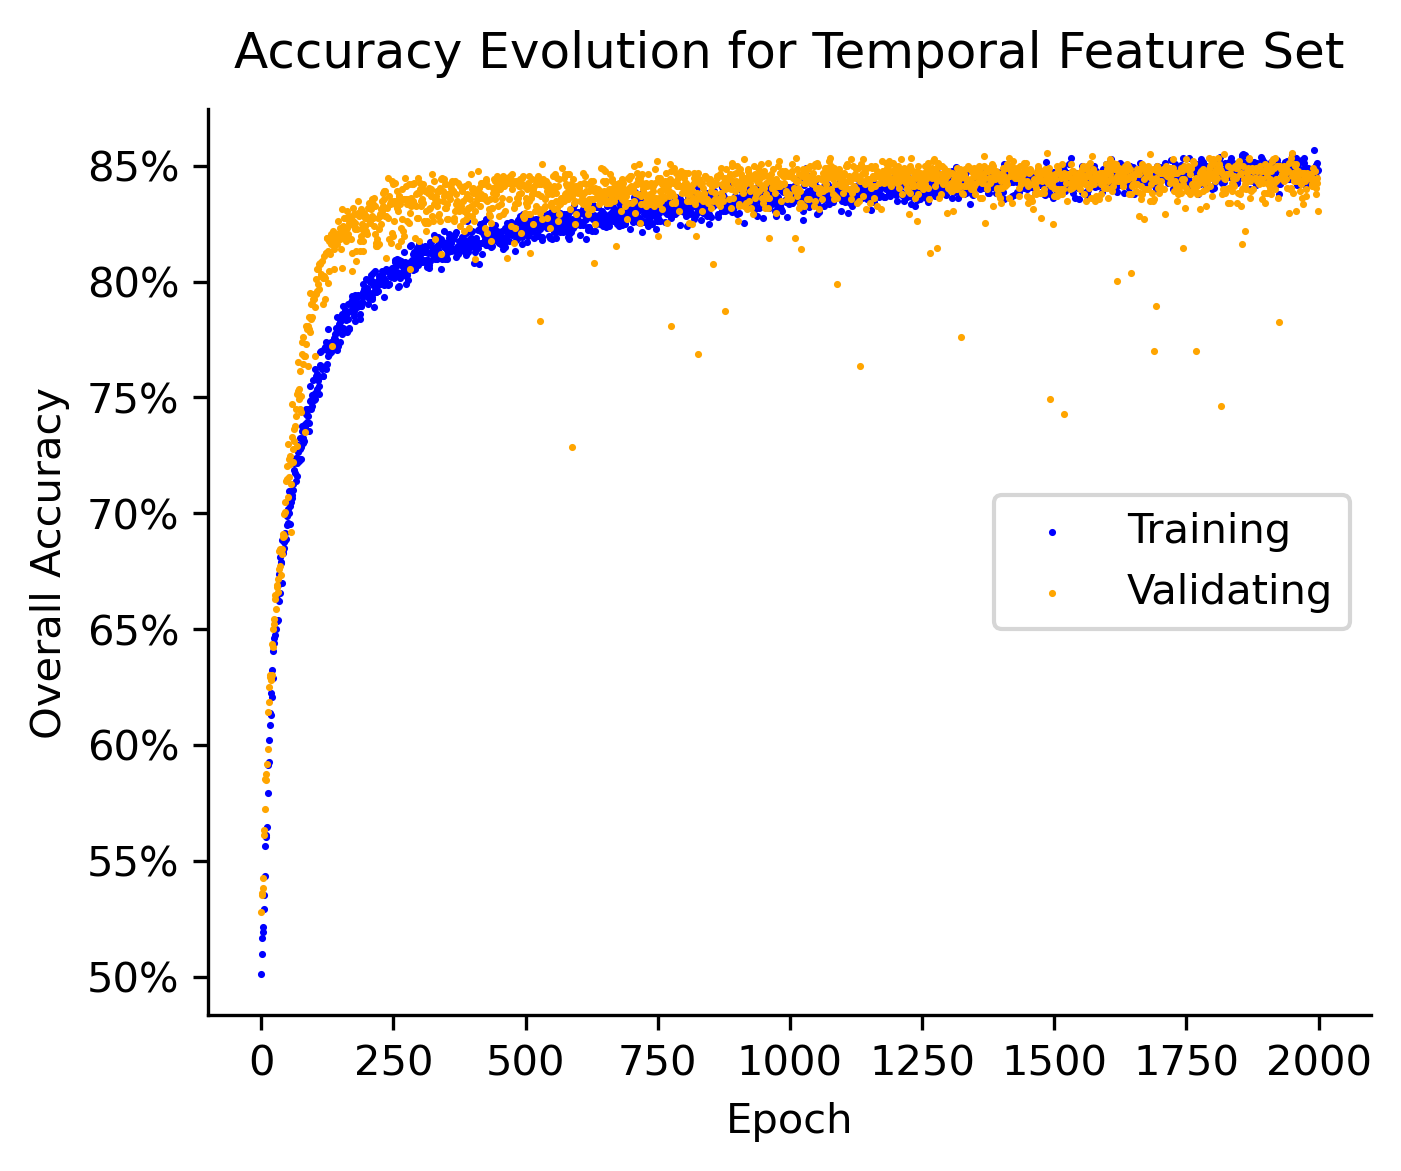

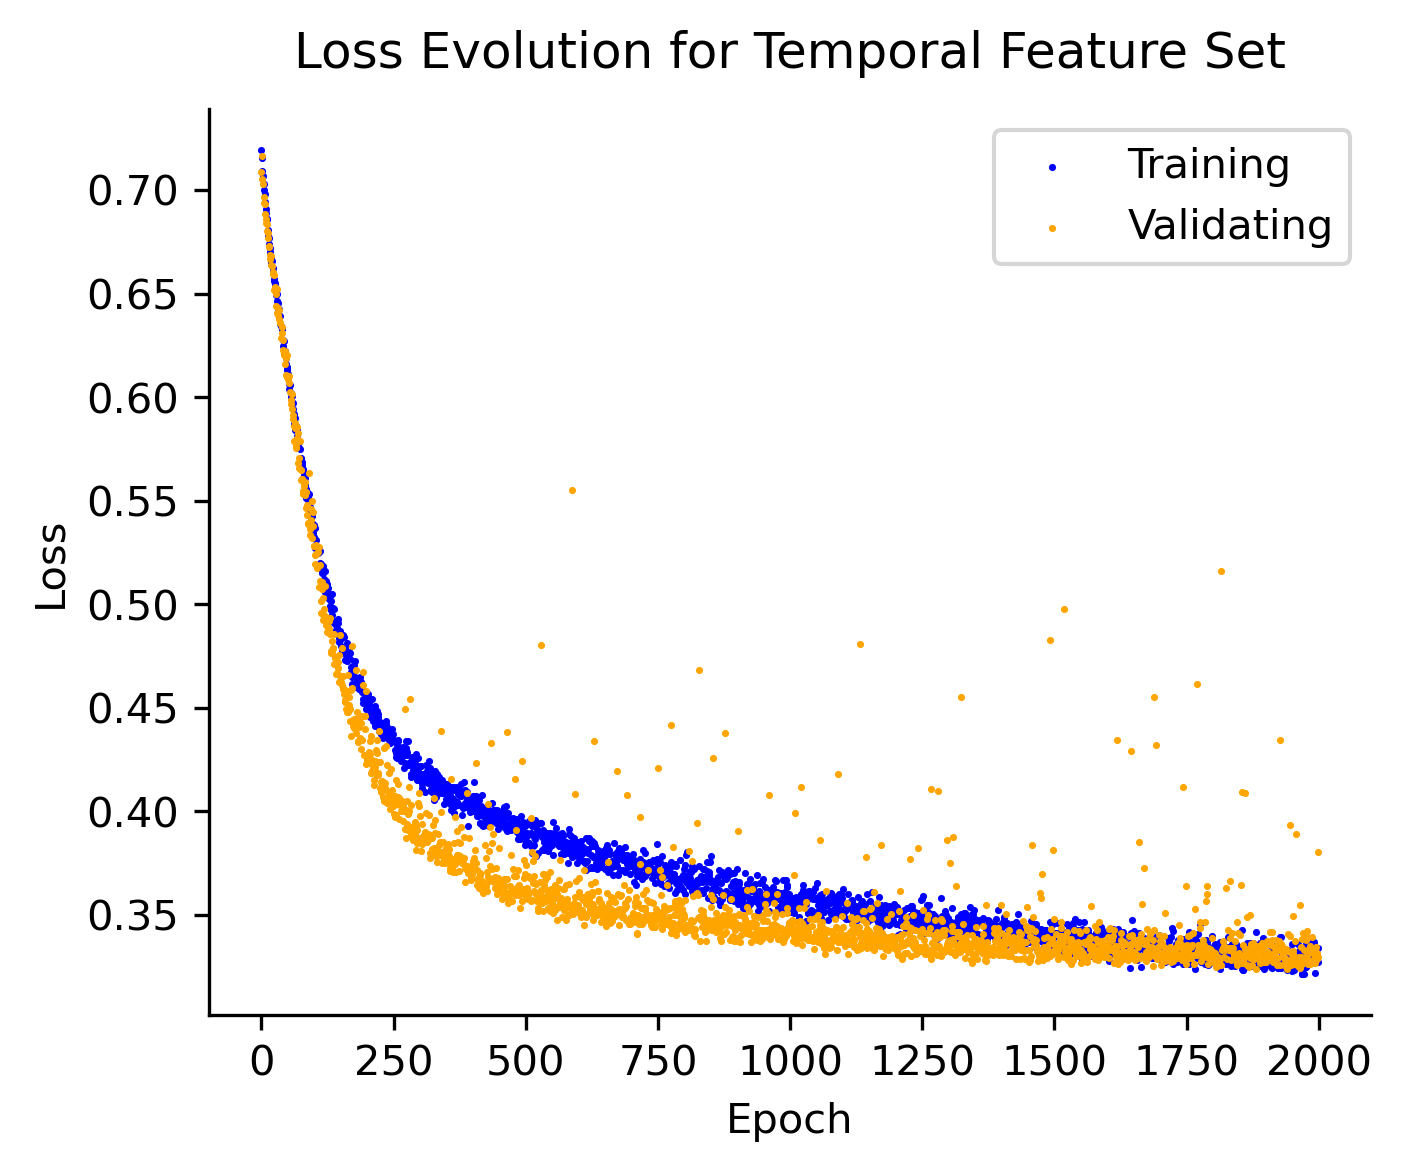

In [289]:
train_loss = np.array(train_loss_temporal)
train_acc = np.array(train_acc_temporal)
val_loss = np.array(val_loss_temporal)
val_acc = np.array(val_acc_temporal)

fig, ax1 = plt.subplots(1, 1, figsize=(5,4), dpi = 300, facecolor = 'w')
ax1.scatter(range(0,len(train_acc)), train_acc*100, s=0.5, c='b', label='Training')
ax1.scatter(range(0,len(val_acc)), val_acc*100, s=0.5, c='orange', label='Validating')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.yaxis.set_major_formatter(PercentFormatter(decimals = 0))
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Overall Accuracy')
ax1.set_title('Accuracy Evolution for Temporal Feature Set', pad = 10)
ax1.legend(loc='center right')
plt.show()

fig, ax1 = plt.subplots(1, figsize=(5,4), dpi = 300, facecolor = 'w')
ax1.scatter(range(0,len(train_loss)), train_loss, s=0.5, c='b', label='Training')
ax1.scatter(range(0,len(val_loss)), val_loss, s=0.5, c='orange', label='Validating')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss Evolution for Temporal Feature Set', pad = 10)
ax1.legend(loc='upper right')
plt.show()

In [223]:
modelTemporal.save_model()

All features except subject data

In [212]:
modelNoSubject = Model((len(features_no_subject.columns)-1,40,20,1), nn.ReLU(),'/Users/Tom/Documents/VSCode/Vela/','no subject model')

In [213]:
train_loss_no_subject, train_acc_no_subject, val_loss_no_subject, val_acc_no_subject = training_loop(nn.BCEWithLogitsLoss(), torch.optim.Adam(modelNoSubject.parameters(), lr = 1e-5), 2000, modelNoSubject, train_loader_no_subject, val_loader_no_subject)

Epoch 1/2000, Train Loss: 0.6800, Train Acc: 0.5750, Val Loss: 0.6791, Val Acc: 0.5889
Epoch 2/2000, Train Loss: 0.6779, Train Acc: 0.5880, Val Loss: 0.6777, Val Acc: 0.6087
Epoch 3/2000, Train Loss: 0.6758, Train Acc: 0.5945, Val Loss: 0.6748, Val Acc: 0.6093
Epoch 4/2000, Train Loss: 0.6730, Train Acc: 0.5932, Val Loss: 0.6711, Val Acc: 0.6023
Epoch 5/2000, Train Loss: 0.6705, Train Acc: 0.5960, Val Loss: 0.6719, Val Acc: 0.6187
Epoch 6/2000, Train Loss: 0.6695, Train Acc: 0.5998, Val Loss: 0.6709, Val Acc: 0.6023
Epoch 7/2000, Train Loss: 0.6684, Train Acc: 0.5993, Val Loss: 0.6689, Val Acc: 0.6012
Epoch 8/2000, Train Loss: 0.6651, Train Acc: 0.6036, Val Loss: 0.6668, Val Acc: 0.6000
Epoch 9/2000, Train Loss: 0.6638, Train Acc: 0.5996, Val Loss: 0.6660, Val Acc: 0.6087
Epoch 10/2000, Train Loss: 0.6634, Train Acc: 0.6028, Val Loss: 0.6651, Val Acc: 0.5965
Epoch 11/2000, Train Loss: 0.6624, Train Acc: 0.6078, Val Loss: 0.6633, Val Acc: 0.6035
Epoch 12/2000, Train Loss: 0.6601, Train 

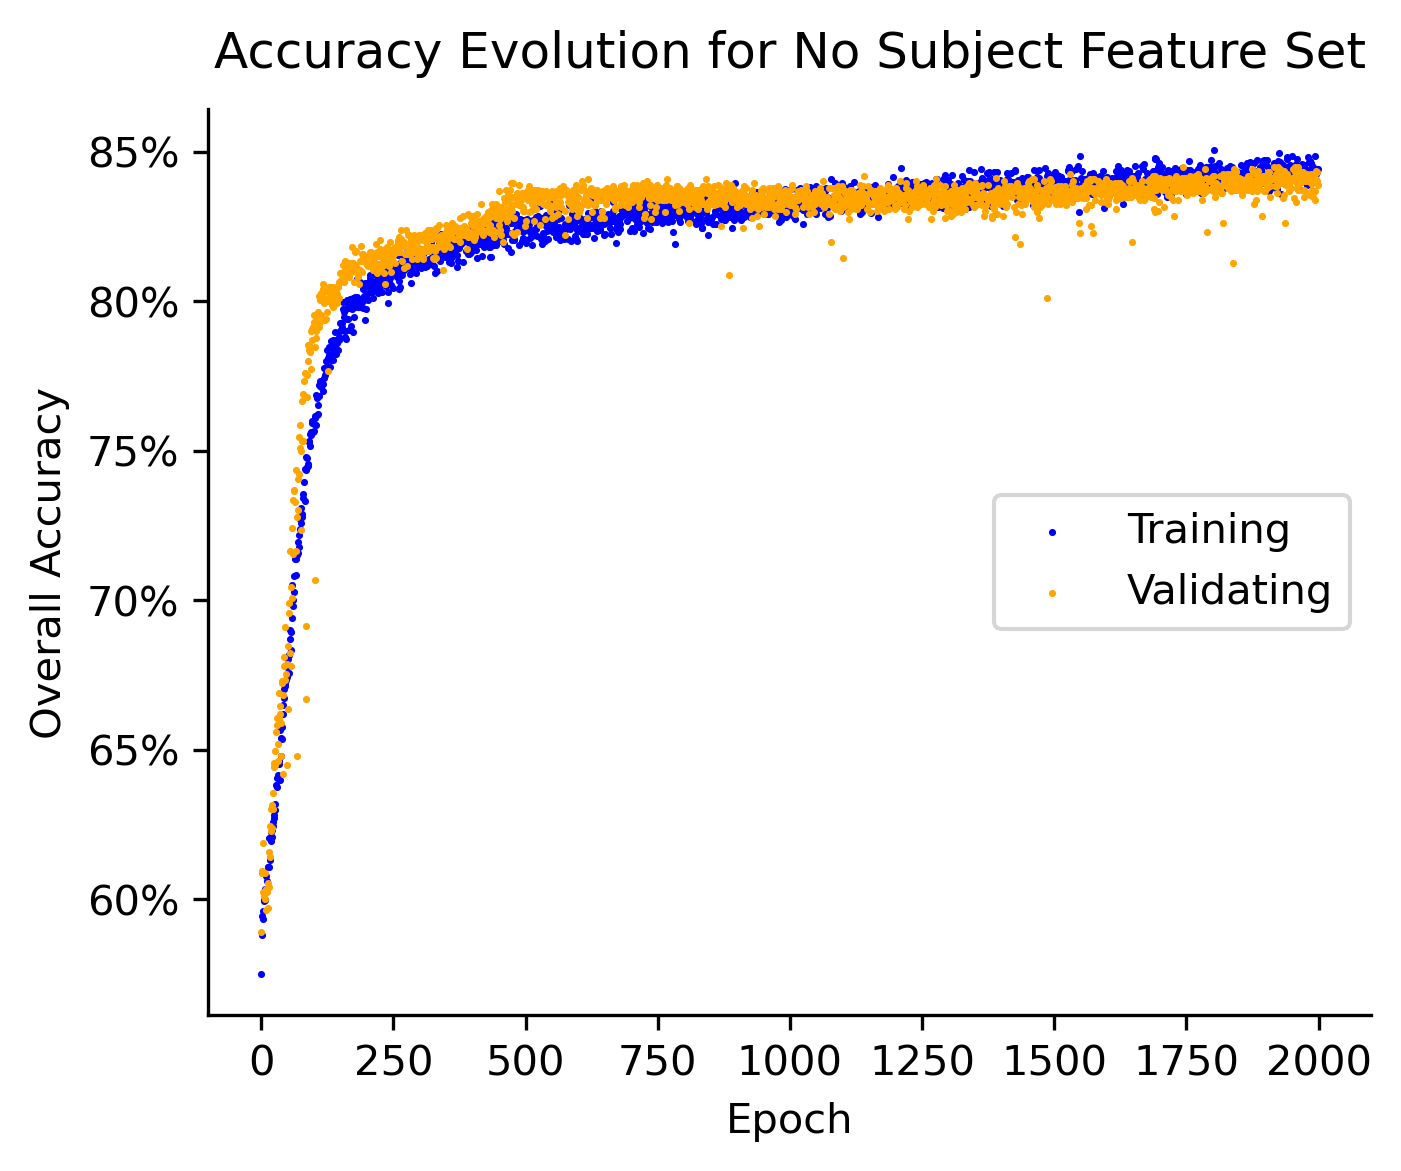

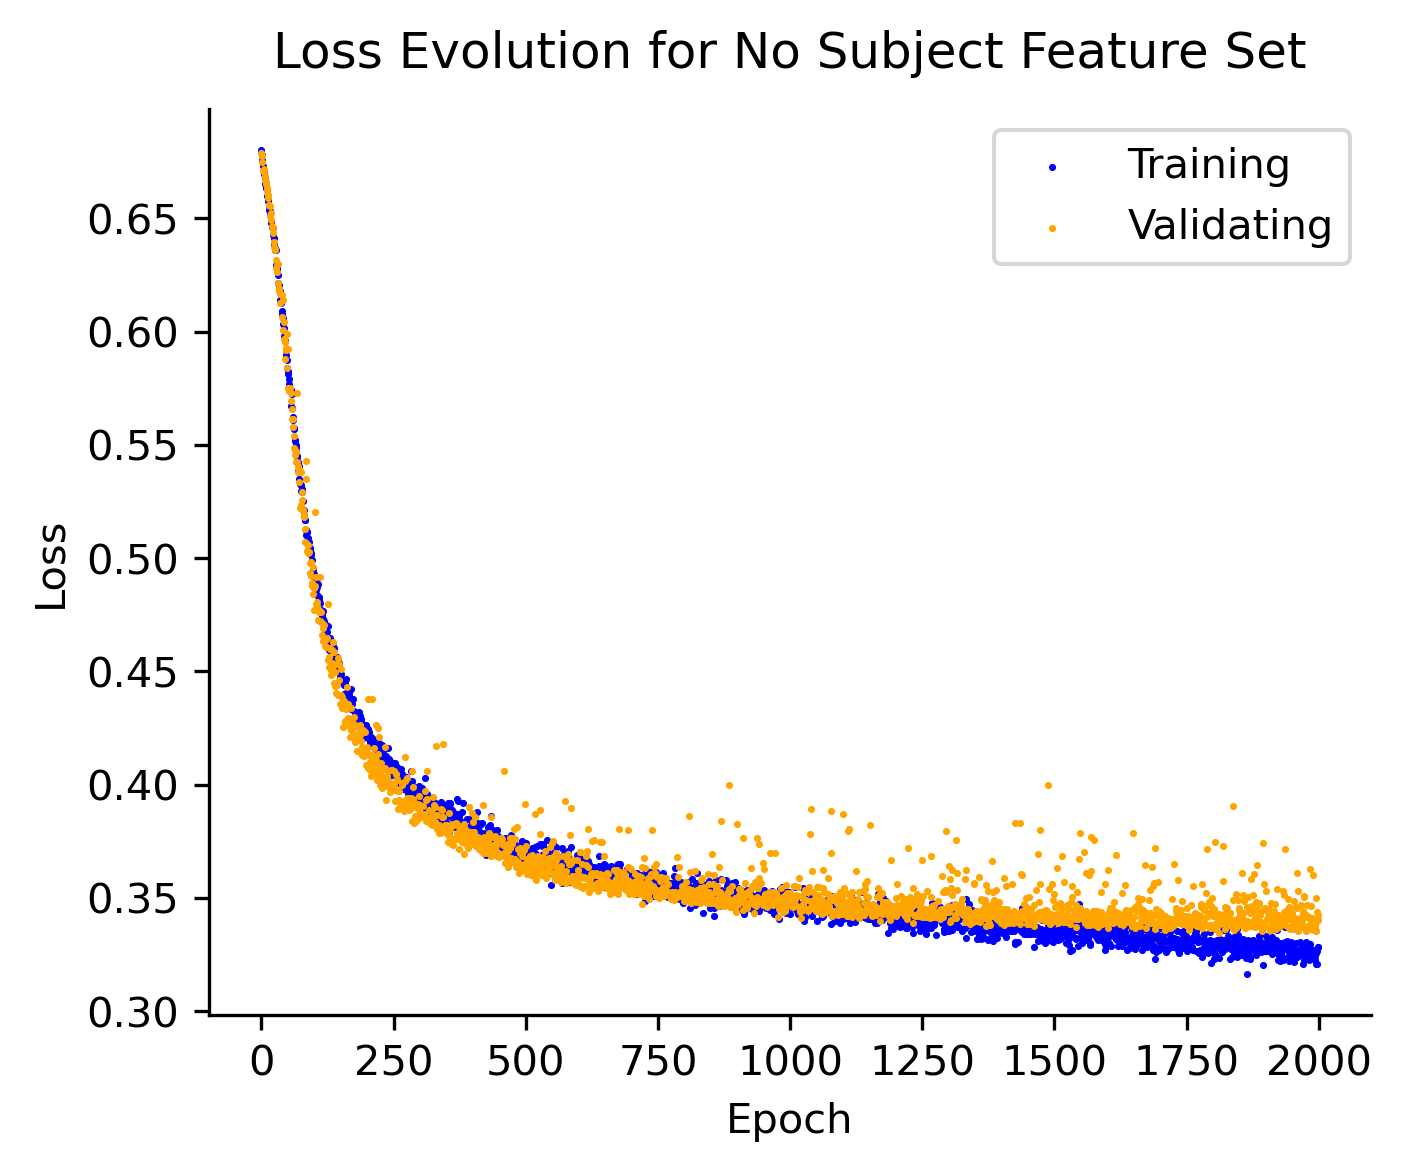

In [292]:
train_loss = np.array(train_loss_no_subject)
train_acc = np.array(train_acc_no_subject)
val_loss = np.array(val_loss_no_subject)
val_acc = np.array(val_acc_no_subject)

fig, ax1 = plt.subplots(1, 1, figsize=(5,4), dpi = 300, facecolor = 'w')
ax1.scatter(range(0,len(train_acc)), train_acc*100, s=0.5, c='b', label='Training')
ax1.scatter(range(0,len(val_acc)), val_acc*100, s=0.5, c='orange', label='Validating')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.yaxis.set_major_formatter(PercentFormatter(decimals = 0))
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Overall Accuracy')
ax1.set_title('Accuracy Evolution for No Subject Feature Set', pad = 10)
ax1.legend(loc='center right')
plt.show()

fig, ax1 = plt.subplots(1, figsize=(5,4), dpi = 300, facecolor = 'w')
ax1.scatter(range(0,len(train_loss)), train_loss, s=0.5, c='b', label='Training')
ax1.scatter(range(0,len(val_loss)), val_loss, s=0.5, c='orange', label='Validating')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss Evolution for No Subject Feature Set', pad = 10)
ax1.legend(loc='upper right')
plt.show()

In [224]:
modelNoSubject.save_model()

All features

In [153]:
# Best
modelAll = Model((len(features.columns)-1,40,20,1), nn.ReLU(),'/Users/Tom/Documents/VSCode/Vela/','all features model')

In [154]:
train_loss, train_acc, val_loss, val_acc = training_loop(nn.BCEWithLogitsLoss(), torch.optim.Adam(modelAll.parameters(), lr = 1e-5), 2000, modelAll, train_loader_all, val_loader_all)

Epoch 1/2000, Train Loss: 0.6864, Train Acc: 0.5640, Val Loss: 0.6924, Val Acc: 0.5458
Epoch 2/2000, Train Loss: 0.6864, Train Acc: 0.5621, Val Loss: 0.6888, Val Acc: 0.5644
Epoch 3/2000, Train Loss: 0.6832, Train Acc: 0.5751, Val Loss: 0.6867, Val Acc: 0.5784
Epoch 4/2000, Train Loss: 0.6813, Train Acc: 0.5739, Val Loss: 0.6855, Val Acc: 0.5808
Epoch 5/2000, Train Loss: 0.6792, Train Acc: 0.5807, Val Loss: 0.6843, Val Acc: 0.5825
Epoch 6/2000, Train Loss: 0.6776, Train Acc: 0.5866, Val Loss: 0.6802, Val Acc: 0.5889
Epoch 7/2000, Train Loss: 0.6764, Train Acc: 0.5850, Val Loss: 0.6789, Val Acc: 0.5872
Epoch 8/2000, Train Loss: 0.6750, Train Acc: 0.5938, Val Loss: 0.6774, Val Acc: 0.5883
Epoch 9/2000, Train Loss: 0.6718, Train Acc: 0.5925, Val Loss: 0.6748, Val Acc: 0.5936
Epoch 10/2000, Train Loss: 0.6699, Train Acc: 0.6022, Val Loss: 0.6749, Val Acc: 0.5918
Epoch 11/2000, Train Loss: 0.6717, Train Acc: 0.5985, Val Loss: 0.6735, Val Acc: 0.5948
Epoch 12/2000, Train Loss: 0.6691, Train 

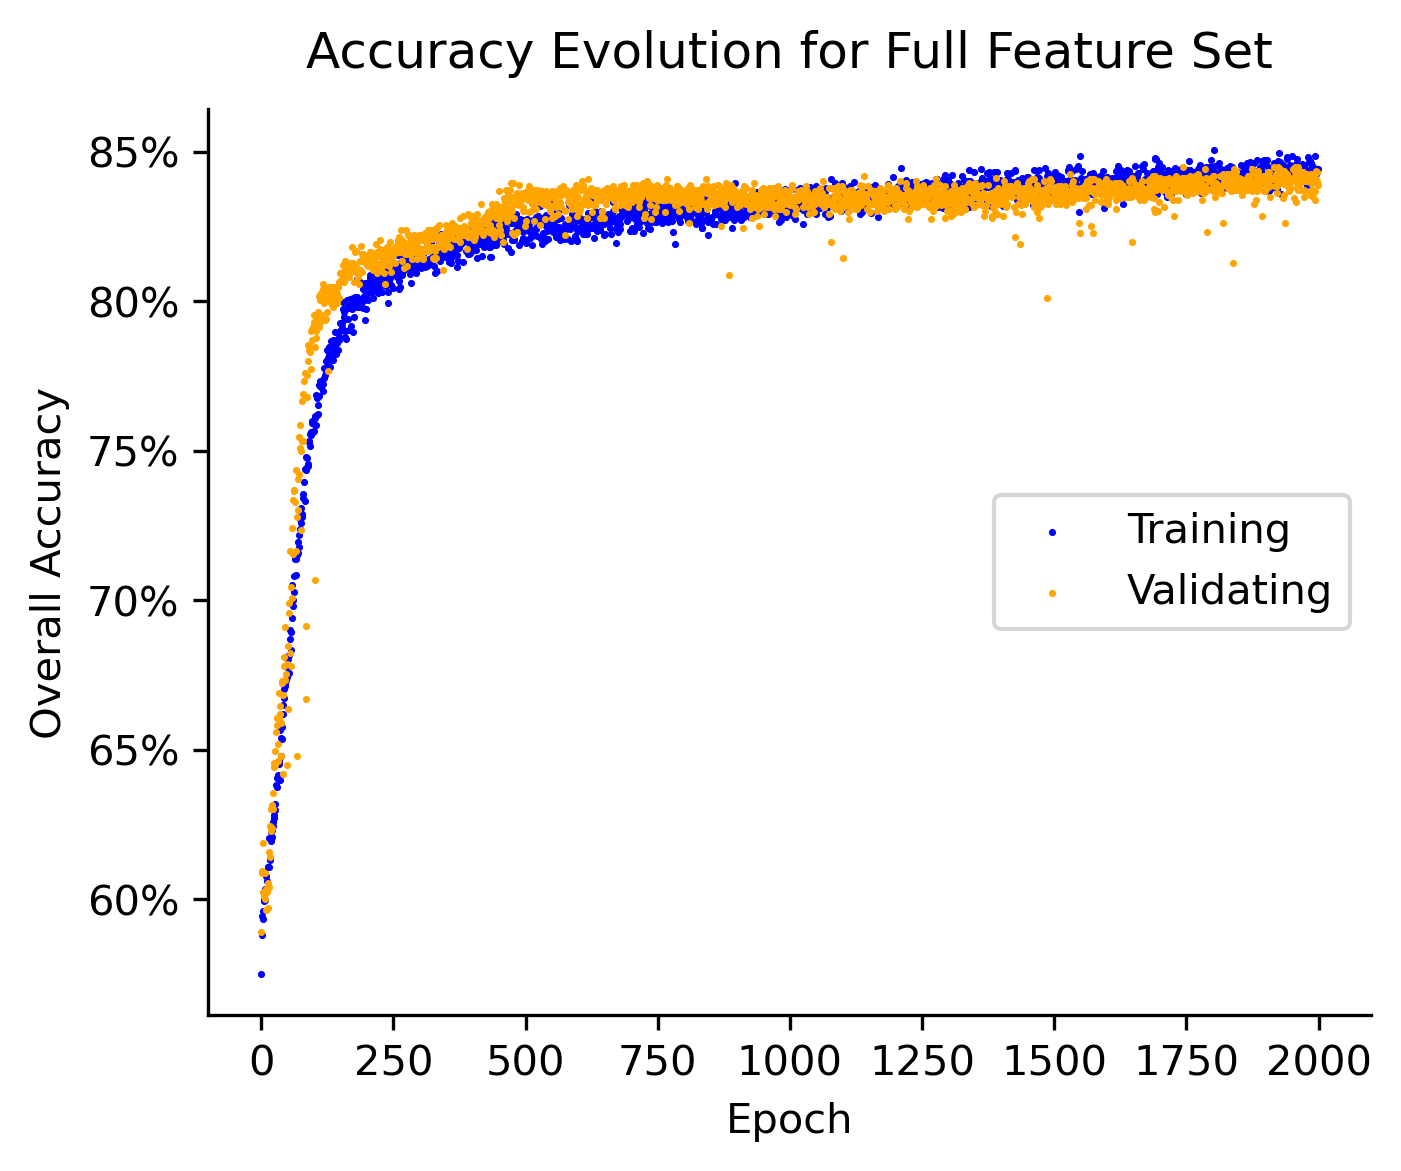

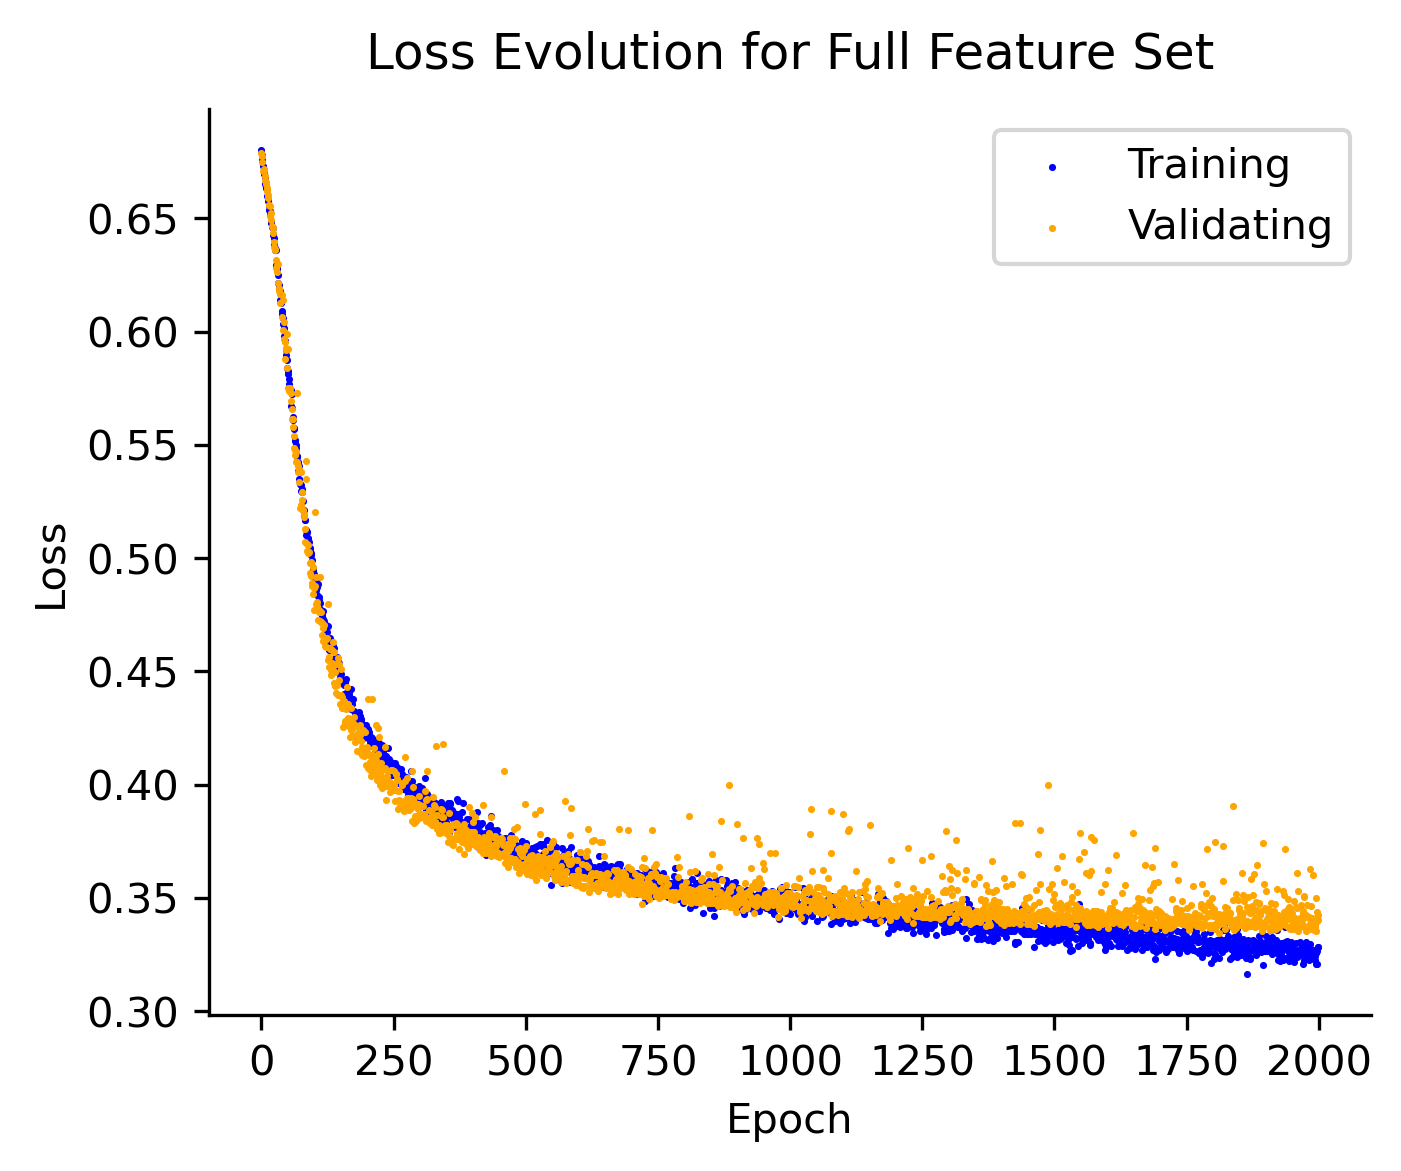

In [293]:
train_loss = np.array(train_loss)
train_acc = np.array(train_acc)
val_loss = np.array(val_loss)
val_acc = np.array(val_acc)

fig, ax1 = plt.subplots(1, 1, figsize=(5,4), dpi = 300, facecolor = 'w')
ax1.scatter(range(0,len(train_acc)), train_acc*100, s=0.5, c='b', label='Training')
ax1.scatter(range(0,len(val_acc)), val_acc*100, s=0.5, c='orange', label='Validating')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.yaxis.set_major_formatter(PercentFormatter(decimals = 0))
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Overall Accuracy')
ax1.set_title('Accuracy Evolution for Full Feature Set', pad = 10)
ax1.legend(loc='center right')
plt.show()

fig, ax1 = plt.subplots(1, figsize=(5,4), dpi = 300, facecolor = 'w')
ax1.scatter(range(0,len(train_loss)), train_loss, s=0.5, c='b', label='Training')
ax1.scatter(range(0,len(val_loss)), val_loss, s=0.5, c='orange', label='Validating')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss Evolution for Full Feature Set', pad = 10)
ax1.legend(loc='upper right')
plt.show()

In [225]:
modelAll.save_model()

Testing:

In [243]:
temp_loss, temp_acc, temp_cm = test_func(nn.BCEWithLogitsLoss(), modelTemporal, test_loader_temporal)
print(temp_cm)

0
Test Loss: 0.3880, Test Acc: 0.8475
[[268 106]
 [ 12 388]]


In [231]:
no_subject_loss, no_subject_acc, no_subject_cm = test_func(nn.BCEWithLogitsLoss(), modelNoSubject, test_loader_no_subject)
print(no_subject_cm)

Test Loss: 0.3379, Test Acc: 0.8426
[[463 119]
 [ 31 340]]


In [232]:
all_loss, all_acc, all_cm = test_func(nn.BCEWithLogitsLoss(), modelAll, test_loader_all)
print(all_cm)

Test Loss: 0.3519, Test Acc: 0.8416
[[470 112]
 [ 39 332]]


In [300]:

def plot_confusion_matrix(cm, classes, normalize=False, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(f'True positive rate: {cm[1,1]/(cm[1,1]+cm[1,0])*100:.2f}%\nTrue negative rate: {cm[0,0]/(cm[0,0]+cm[0,1])*100:.2f}%\nFalse positive rate: {cm[0,1]/(cm[0,1]+cm[0,0])*100:.2f}%\nFalse negative rate: {cm[1,0]/(cm[1,0]+cm[1,1])*100:.2f}%\n')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion Matrix')
    ###plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    ###plt.savefig('CM', dpi = 300)
    plt.show()

In [246]:
temp_cm[1,0]

12

Confusion matrix, without normalization
True positive rate: 97.00%
True negative rate: 71.66%
False positive rate: 28.34%
False negative rate: 3.00%



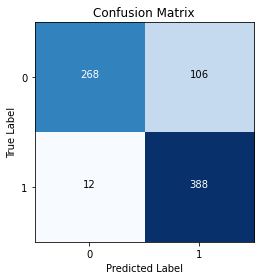

In [297]:
# Temporal
plot_confusion_matrix(temp_cm, [0,1])

Confusion matrix, without normalization
True positive rate: 91.64%
True negative rate: 79.55%
False positive rate: 20.45%
False negative rate: 8.36%



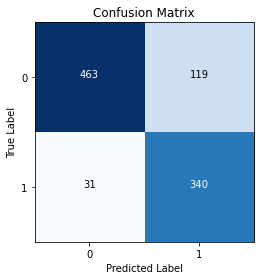

In [298]:
# No subject
plot_confusion_matrix(no_subject_cm, [0,1])

Confusion matrix, without normalization
True positive rate: 89.49%
True negative rate: 80.76%
False positive rate: 19.24%
False negative rate: 10.51%



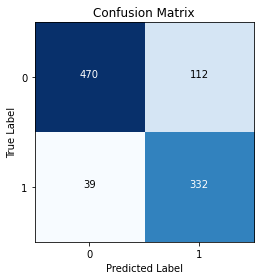

In [299]:
# All features
plot_confusion_matrix(all_cm, [0,1])